# Exercícios

1. Plotar algumas imagens do dataset fashion MNIST para ter uma idea de como são as amostras.
1. Estimar os rótulos das amostras de teste, computar a acurácia e gerar uma matriz de confusão para ver com quais classes cada classe está se confundindo.
1. Rodar esse algoritmo utilizando o dataset Kuzushiji-MNIST (KMNIST). Pesquisar para fazer aumento de dados (transform) com horizontal flipping. Plotar algumas imagens desse dataset também.

---

## 1. Bibliotecas

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [2]:
#  Verificando a versão do PyTorch e se está usando GPU
print('Versão PyTorch: ', torch.__version__)
print('Usando GPU: ', torch.cuda.is_available())

if torch.cuda.is_available():    
    print('GPU: ',torch.cuda.get_device_name(torch.cuda.current_device()))

Versão PyTorch:  1.8.1
Usando GPU:  False


## 2. Download dos dados

In [3]:
train_fdataset = dsets.FashionMNIST(root='~/data', train=True, transform=transforms.ToTensor(), download=True)
test_fdataset = dsets.FashionMNIST(root='~/data', train=False, transform=transforms.ToTensor())

In [4]:
print(f"> {len(train_fdataset)} amostras de Treino e {len(test_fdataset)} amostras de Teste")

> 60000 amostras de Treino e 10000 amostras de Teste


In [5]:
train_Kdataset = dsets.KMNIST(root='~/data', train=True, transform=transforms.ToTensor(), download=True)
test_Kdataset = dsets.KMNIST(root='~/data', train=False, transform=transforms.ToTensor())

In [6]:
print(f"> {len(train_Kdataset)} amostras de Treino e {len(test_Kdataset)} amostras de Teste")

> 60000 amostras de Treino e 10000 amostras de Teste


---

# Fashion MNIST

## 1. Plotando algumas imagens

In [7]:
import matplotlib.pyplot as plt

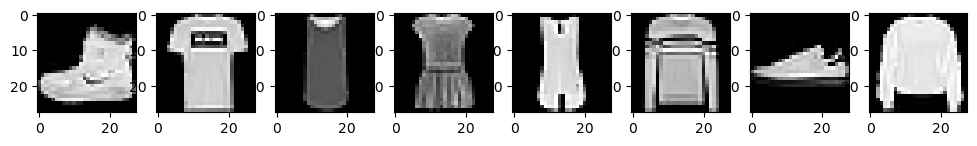

In [8]:
num_imagens = 8

fig, axs = plt.subplots(1, num_imagens, figsize=(12,4))
for i in range(num_imagens):
    axs[i].imshow(train_fdataset[i][0].reshape(28,28), cmap=plt.get_cmap("gray"))

plt.show()

## 2. Criando o modelo

### 2a. Data loader

In [9]:
batch_size = 200

train_loader = torch.utils.data.DataLoader(dataset=train_fdataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_fdataset, batch_size=batch_size, shuffle=False)

### 2b. Classe modelo

In [10]:
from logisticregression import *

### 2c. Definindo hyperparâmetros e instanciando o modelo

In [11]:
n_iters = 5000
epochs = n_iters/(len(train_fdataset)/batch_size)
input_dim = 784
output_dim = 10
lr_rate = 0.01

In [12]:
model = LogisticRegression(input_dim, output_dim)

### 2d. Instanciando a classe Loss

In [13]:
criterion = torch.nn.CrossEntropyLoss()

### 2e. Definindo otimizador

In [14]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

### 2f. Treinando o modelo

In [15]:
from torch.autograd import Variable

In [16]:
iter = 0
for epoch in range(int(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter+=1
        if iter%500==0:
            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images.view(-1, 28*28))
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct.float()/total
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.7699894905090332. Accuracy: 72.94999694824219.
Iteration: 1000. Loss: 0.6135164499282837. Accuracy: 76.29000091552734.
Iteration: 1500. Loss: 0.7222177982330322. Accuracy: 78.0199966430664.
Iteration: 2000. Loss: 0.6998457312583923. Accuracy: 78.95999908447266.
Iteration: 2500. Loss: 0.6024200320243835. Accuracy: 79.72000122070312.
Iteration: 3000. Loss: 0.5613698363304138. Accuracy: 80.26000213623047.
Iteration: 3500. Loss: 0.5011137127876282. Accuracy: 80.77999877929688.
Iteration: 4000. Loss: 0.48856544494628906. Accuracy: 80.98999786376953.
Iteration: 4500. Loss: 0.56577467918396. Accuracy: 81.01000213623047.


## 3. Estimando os rótulos das amostras de teste

In [17]:
predicted = []
expected = []

for image, label in test_fdataset:
    image = Variable(image.view(-1, 28*28))
    outputs = model(image)
    _, prediction = torch.max(outputs.data, 1)
    predicted.append(prediction.item())
    expected.append(label)

In [18]:
import pandas as pd

In [19]:
results = pd.DataFrame({'predicted': predicted, 'expected':expected})
results

,predicted,expected
0,9,9
1,2,2
2,1,1
3,1,1
4,6,6
...,...,...
9995,9,9
9996,1,1
9997,8,8
9998,1,1


## 4. Avaliando o modelo

### 4a. Acurácia

In [20]:
accuracy = (results['predicted'] == results['expected']).sum()/len(results)
print(f"Acurácia do modelo: {accuracy}")

Acurácia do modelo: 0.8118


### 4b. Matriz de confusão

In [21]:
label_dict = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
              5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

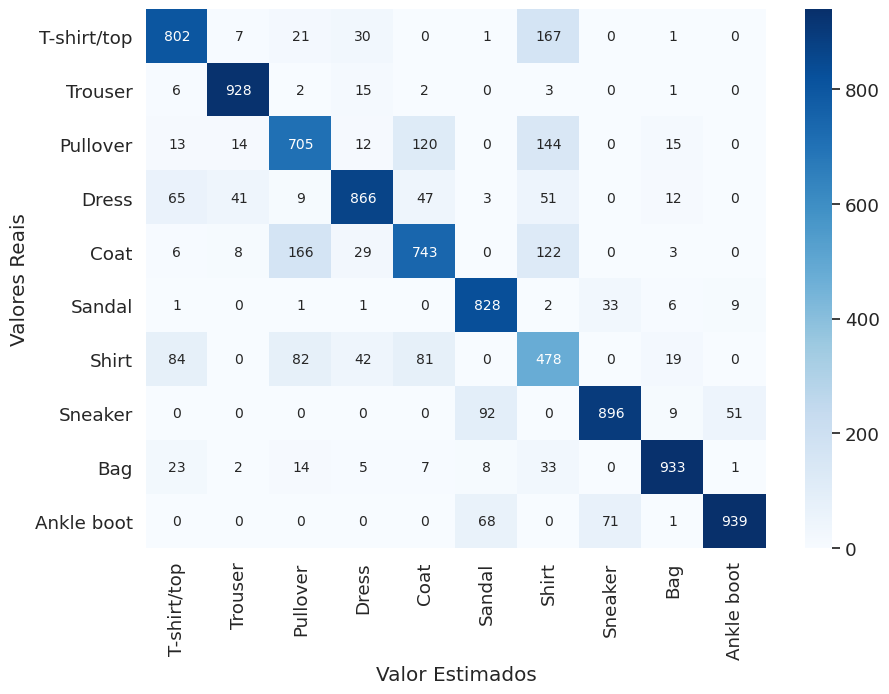

In [23]:
cm = confusion_matrix(predicted, expected)
df_cm = pd.DataFrame(cm, columns=label_dict.values(), index=label_dict.values())
df_cm.index.name = "Valores Reais"
df_cm.columns.name = "Valor Estimados"
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 10})
plt.show()

---

# Kuzushiji-MNIST

## 1. Plotando algumas imagens

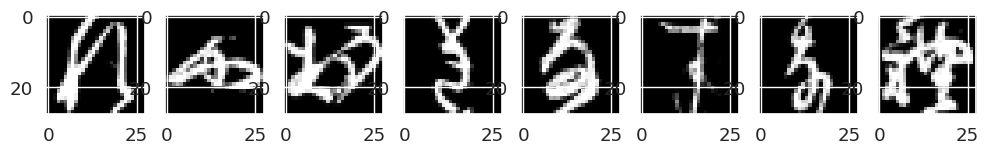

In [24]:
num_imagens = 8

fig, axs = plt.subplots(1, num_imagens, figsize=(12,4))
for i in range(num_imagens):
    axs[i].imshow(train_Kdataset[i][0].reshape(28,28), cmap=plt.get_cmap("gray"))

plt.show()

## 2. Criando o modelo

### 2a. Data loader

In [25]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_Kdataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_Kdataset, batch_size=batch_size, shuffle=False)

### 2b. Definindo hyperparâmetros e instanciando o modelo

In [26]:
n_iters = 5000
epochs = n_iters/(len(train_Kdataset)/batch_size)
input_dim = 784
output_dim = 10
lr_rate = 0.01

In [27]:
model = LogisticRegression(input_dim, output_dim)

### 2c. Instanciando a classe Loss

In [28]:
criterion = torch.nn.CrossEntropyLoss()

### 2d. Definindo otimizador

In [29]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

### 2e. Treinando o modelo

In [30]:
iter = 0
for epoch in range(int(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter+=1
        if iter%500==0:
            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images.view(-1, 28*28))
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct.float()/total
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.9499350190162659. Accuracy: 55.95000076293945.
Iteration: 1000. Loss: 0.9553491473197937. Accuracy: 60.84000015258789.
Iteration: 1500. Loss: 0.646698534488678. Accuracy: 62.810001373291016.
Iteration: 2000. Loss: 0.8490260243415833. Accuracy: 64.30000305175781.
Iteration: 2500. Loss: 0.6206724643707275. Accuracy: 64.62999725341797.
Iteration: 3000. Loss: 0.7130780816078186. Accuracy: 65.5199966430664.
Iteration: 3500. Loss: 0.6925485730171204. Accuracy: 65.76000213623047.
Iteration: 4000. Loss: 0.6255356073379517. Accuracy: 66.08000183105469.
Iteration: 4500. Loss: 0.5406478047370911. Accuracy: 66.33999633789062.


## 3. Estimando os rótulos das amostras de teste

In [31]:
predicted = []
expected = []

for image, label in test_Kdataset:
    image = Variable(image.view(-1, 28*28))
    outputs = model(image)
    _, prediction = torch.max(outputs.data, 1)
    predicted.append(prediction.item())
    expected.append(label)

In [32]:
results = pd.DataFrame({'predicted': predicted, 'expected':expected})
results

,predicted,expected
0,5,2
1,9,9
2,3,3
3,8,8
4,3,3
...,...,...
9995,9,4
9996,0,0
9997,9,9
9998,0,4


## 4. Avaliando o modelo

### 4a. Acurácia

In [33]:
accuracy = (results['predicted'] == results['expected']).sum()/len(results)
print(f"Acurácia do modelo: {accuracy}")

Acurácia do modelo: 0.6643


### 4b. Matriz de confusão

In [34]:
label_dict = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
              5:'Sandal', 6:dd'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

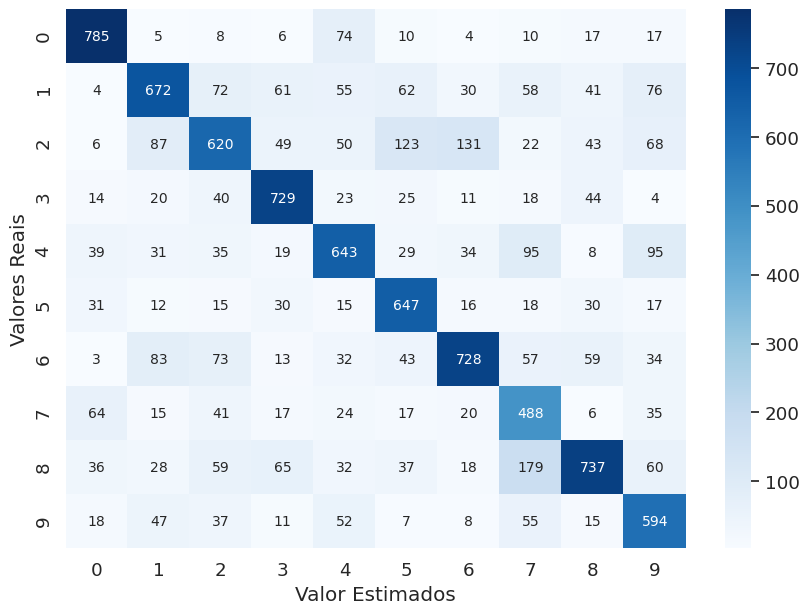

In [37]:
cm = confusion_matrix(predicted, expected)
df_cm = pd.DataFrame(cm)
df_cm.index.name = "Valores Reais"
df_cm.columns.name = "Valor Estimados"
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 10})
plt.show()